In [2]:
#@title Librerias
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp

# Parcial III - Métodos Computacionales

### Nombre:

---

## ⚠ Importante

👁 Puede usar unicamente las librerias vistas en clase (estas están en la parte superior) en caso de agregar una nueva, debe justificarla.

💀 No está permitido el uso de IA's en caso de hacerlo su parcial será **anulado**!

❗ Comente su código y funciones, esto hace parte de la nota.

✅ Responda ordenadamente y con claridad.


---

# 1

(**35 puntos**) El **método de Jacobi** es un algoritmo iterativo para resolver sistemas lineales de la forma:

$$
A \mathbf{x} = \mathbf{b},
$$

donde \$A\$ es una matriz cuadrada no singular. A diferencia del método de Gauss-Seidel, Jacobi utiliza exclusivamente los valores de la iteración anterior para actualizar todas las variables simultáneamente, lo que lo hace más sencillo de paralelizar pero, en general, con una convergencia más lenta.

## Algoritmo

Dado un sistema lineal \$A \mathbf{x} = \mathbf{b}\$, el método de Jacobi consiste en:

1. Elegir un vector inicial \$\mathbf{x}^{(0)}\$ (por ejemplo, el vector nulo).

2. Para cada iteración \$k\$ y cada componente \$i = 1, 2, ..., n\$, actualizar:

$$
x_i^{(k)} = \frac{1}{a_{ii}} \left( b_i - \sum_{\substack{j=1 \\ j \neq i}}^{n} a_{ij} x_j^{(k-1)} \right)
$$

3. Repetir hasta que se cumpla un criterio de convergencia, como:

$$
\| \mathbf{x}^{(k)} - \mathbf{x}^{(k-1)} \| < \text{tolerancia}
$$

---

**a)** Escriba una función llamada `jacobi` que resuelva el sistema lineal \$A \mathbf{x} = \mathbf{b}\$ usando el método iterativo de Jacobi. La función debe aceptar como argumentos:

* La matriz \$A\$ y el vector \$\mathbf{b}\$,
* Una tolerancia (por defecto \$1\times 10^{-10}\$),
* Un número máximo de iteraciones.

Debe retornar la solución aproximada \$\mathbf{x}\$ y el número de iteraciones realizadas.

---

**b)** Aplique su función para resolver el siguiente sistema de ecuaciones lineales:

$$
\begin{cases}
10x_1 - x_2 + 2x_3 = 6 \\[2mm]
-2x_1 + 11x_2 - x_4 = 25 \\[2mm]
3x_1 - x_2 + 10x_3 - x_4 = -11 \\[2mm]
2x_2 - x_3 + 8x_4 = 15
\end{cases}
$$

Use como vector inicial \$\mathbf{x}^{(0)} = \[0, 0, 0, 0]^T\$. Imprima la solución aproximada y el número de iteraciones necesarias para adquirir la convergencia.

---

**c)** Compare su solución con `np.linalg.solve`. ¿Qué tan cercana es la solución iterativa a la exacta? Para esto, realice un gráfico del error usando la norma euclidiana (`np.linalg.norm`) en función de la tolerancia y otro del número de iteraciones, empleando un `np.logspace(-18, -1, 18)`.

---



/tmp/ipython-input-529729315.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


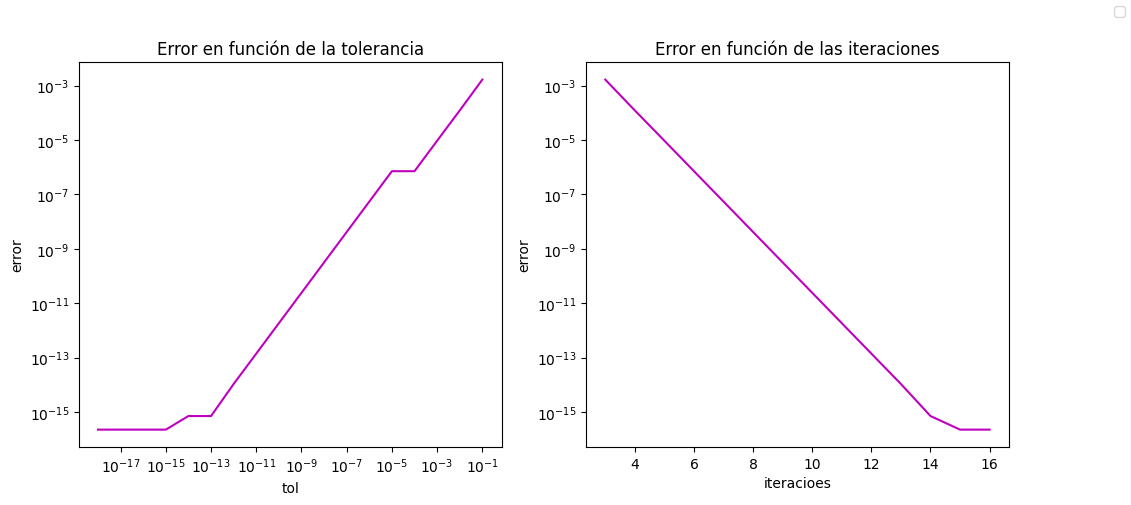

In [96]:
A=np.array([[10,-1,2,0],
            [-1,11,0,-1],
            [3,-1,10,-1],
            [0,2,-1,8]],dtype=float)

b=np.array([6,25,-11,15],dtype=float)


def jacobi(A,b,tol=1e-10,maxiter=100):
  """
  Resuelve una matriz con el método iterativo de Jacobi para ecuaciones de la forma Ax=b

  Recibe
  A: array, matriz
  b: array, solución

  Devuelve
  x: array, solución de la ecuación matricial Ax=b
  """
  x=np.zeros_like(b)
  iter=0
  while True:
    iter+=1
    xant=x.copy()

    for i in range(len(A)):
      suma=0

      for j in range(len(A[0])):
        if j!= i:
          suma+=A[i,j]*x[j]

      x[i]=(1/(A[i,i]))*(b[i]-suma)


    if la.norm(x-xant)<tol:
      break
    if iter>=100:
      raise ValueError("Máximo de iteraciones alcanzado")
  return x,iter

sol_jacobi=jacobi(A,b)[0]
iteraciones=jacobi(A,b)[1]

sol_linalg=la.solve(A,b)

h=np.logspace(-18,-1,18)
error=np.zeros_like(h)
iterarray=np.zeros_like(h)

for i in range(len(h)):  #Es este ciclo se llena un array con el error y otro con las iteraciones
  sol_jacobi=jacobi(A,b,tol=h[i])[0]
  iteraciones=jacobi(A,b,tol=h[i])[1]
  error[i]=la.norm(sol_linalg-sol_jacobi)
  iterarray[i]=iteraciones

fig, ax=plt.subplots(1,2, figsize=(12,5))

ax[0].loglog(h,error, color="m")
ax[0].set(title="Error en función de la tolerancia", xlabel="tol", ylabel="error")
ax[1].semilogy(iterarray, error, color="m")
ax[1].set(title="Error en función de las iteraciones", xlabel="iteracioes", ylabel="error")
fig.legend()

# 2

(**50 puntos**) El sistema **masa-resorte con fricción** es un modelo clásico en física que describe el movimiento de una masa sujeta a una fuerza restauradora (resorte) y una fuerza disipativa (fricción o viscosidad). Su dinámica está gobernada por la ecuación diferencial de segundo orden:

$$
m y''(t) + c y'(t) + k y(t) = 0,
$$

donde:

* $m$ es la masa del objeto,
* $c$ es el coeficiente de fricción (amortiguamiento),
* $k$ es la constante del resorte,
* $y(t)$ es la posición de la masa respecto a su equilibrio.

---

**a)** Reformule esta ecuación como un sistema de primer orden adecuado para ser resuelto con `solve_ivp`. Explique mediante una función explicita y realice su documentación.

---

**b)** Considere el siguiente caso:

* Masa: $m = 1$ kg
* Constante del resorte: $k = 4$ N/m
* Coeficiente de fricción: $c = 0.5$ N·s/m
* Condiciones iniciales: $y(0) = 1$, $y'(0) = 0$
* Intervalo de tiempo: $t \in [0, 20]$

Utilice `solve_ivp` para resolver el sistema y grafique $y(t)$ como $y'(t)$. Interprete el comportamiento del sistema.

---

**c)** Simule dos escenarios adicionales:

1. Sin fricción: $c = 0$
2. Con fuerte fricción: $c = 4.5$

Grafique los tres casos \$y(t)\$ en una misma figura y compare los regímenes: **no amortiguado**, **subamortiguado**, y **sobreamortiguado**.

---

**d)** Para cada uno de los tres casos, calcule la **energía mecánica total** del sistema en función del tiempo. La energía total se define como la suma de energía cinética y potencial:

$$
E(t) = \frac{1}{2} m v^2 + \frac{1}{2} k y^2
$$

Grafique $E(t)$ para los tres escenarios simulados. Analice y compare el comportamiento de la energía en cada caso. ¿Qué sucede con la energía a lo largo del tiempo? ¿Cómo se relaciona esto con el valor del coeficiente de fricción $c$?


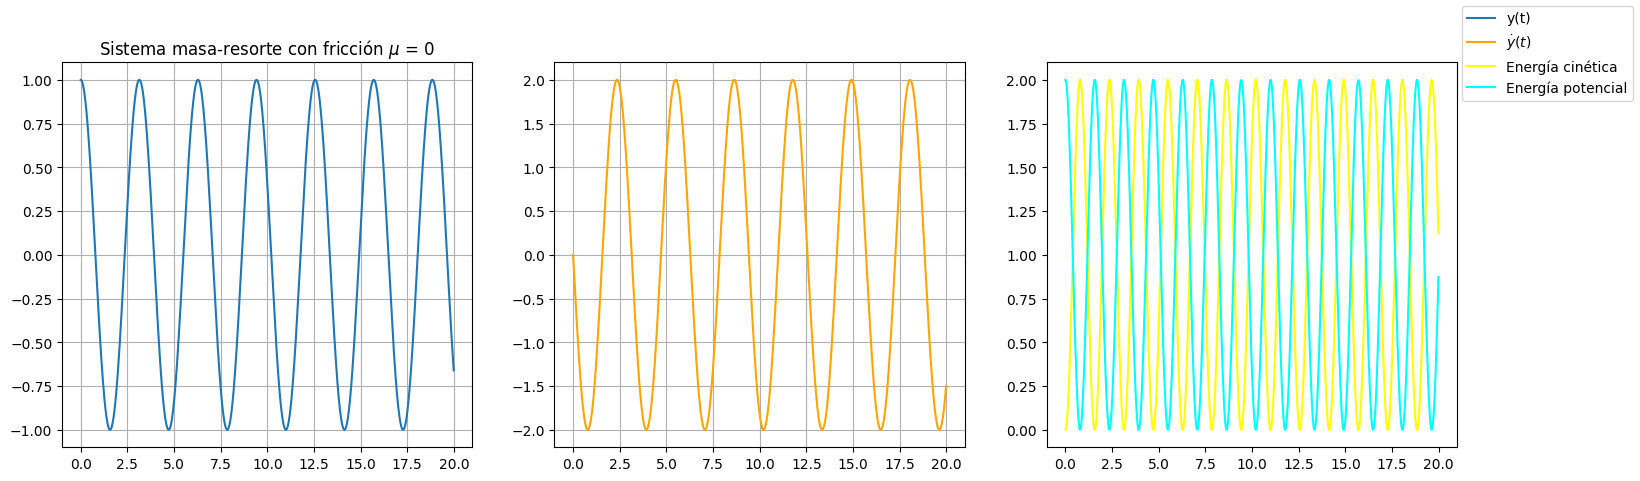

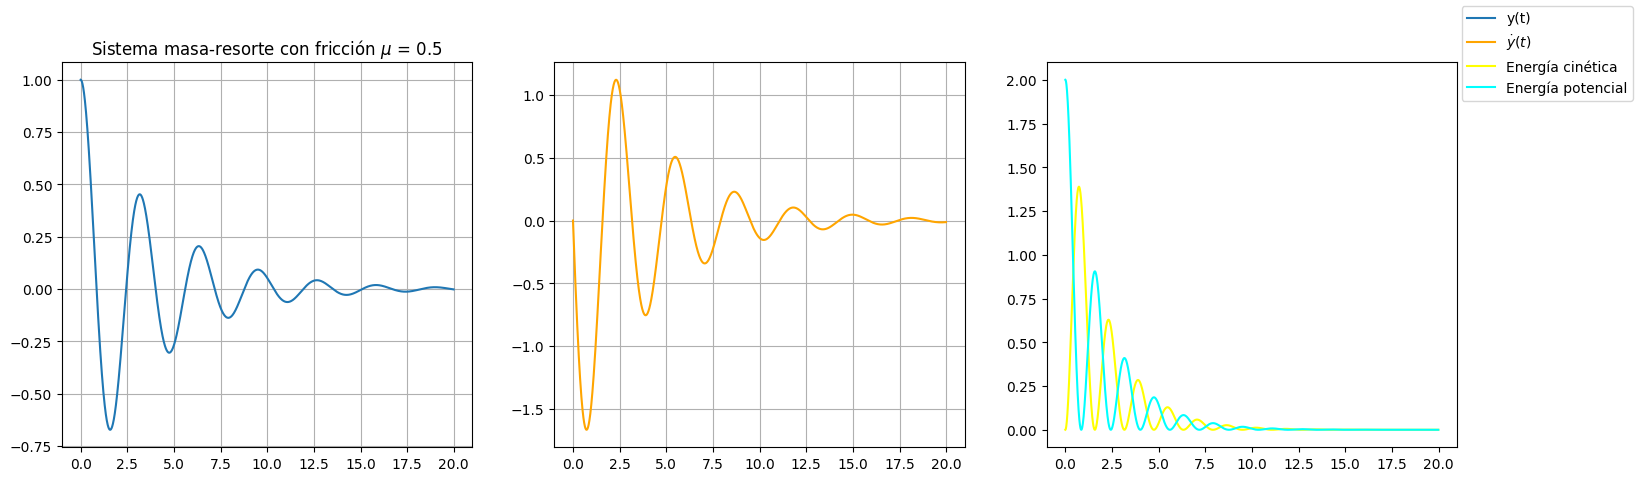

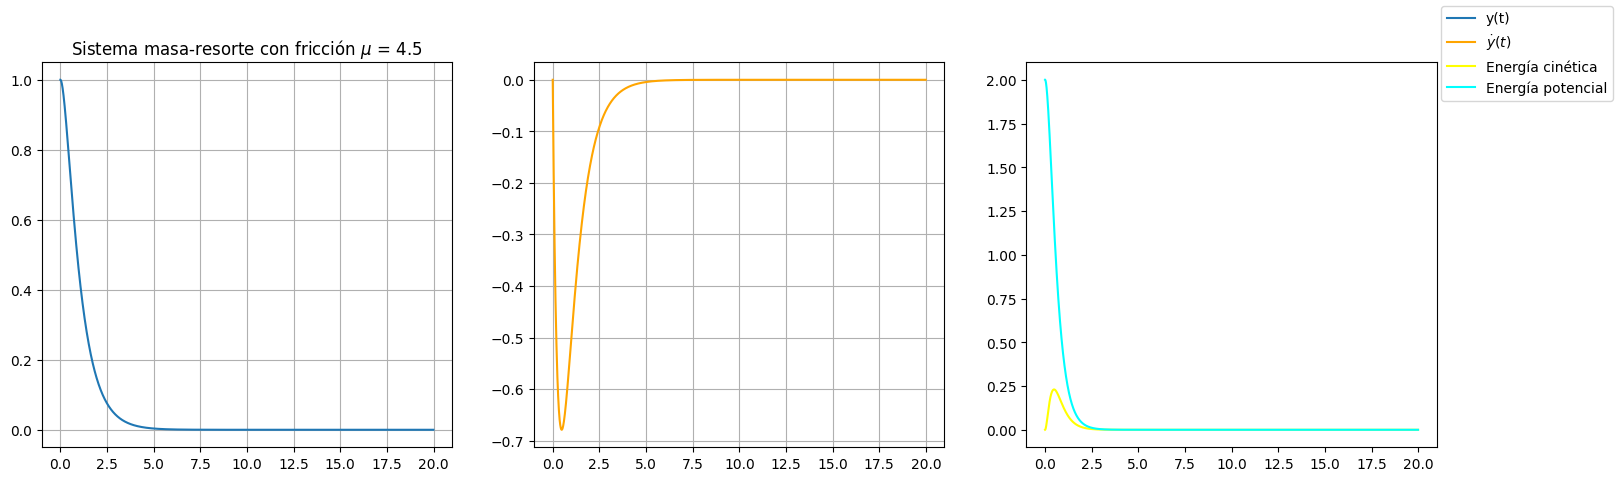

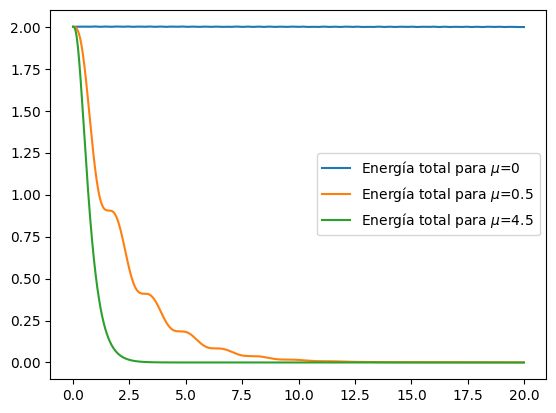

In [93]:
m=1
k=4
c=[0,0.5, 4.5] #Constantes dadas

y0=1
yprima0=0
Y0=np.array([y0,yprima0]) #Condiciones iniciales en forma matricial

t=np.arange(0,20, 0.01)  #El tiempo con h=0.01

def a(t,Y,c):
  """
  Función de la aceleración del sistema masa-resorte con fricción

  Recibe
  t: tiempo
  Y: array con y y yprima
  c: Coeficiente de fricción
  Devuelve
  dY: El array con la velocidad y la aceleración
  """
  dY=np.zeros_like(Y)
  dY[0]=Y[1]
  dY[1]=-(c*Y[1]+k*Y[0])/m
  return dY


for i in c:  #Este es un ciclo útil para hacer todos los puntos al mismo tiempo
  def a2variables(t,Y):
    return a(t,Y, i)
  sol=solve_ivp(a2variables,(t[0],t[-1]), Y0,t_eval=t)
  El=k*(sol.y[0]**2)/2
  Ek=(m*sol.y[1]**2)/2
  fig,ax=plt.subplots(1,3, figsize=(18,5))
  ax[0].plot(t,sol.y[0], label="y(t)")
  ax[0].grid()
  ax[0].set(title=f"Sistema masa-resorte con fricción $\mu$ = {i}")
  ax[1].plot(t,sol.y[1],color="orange", label="$\dot{y}(t)$")
  ax[1].grid()
  ax[2].plot(t,Ek, color="yellow", label="Energía cinética")
  ax[2].plot(t,El, color="cyan", label="Energía potencial")  #Las dos energías separadas, para que se vean aparte

  fig.legend()
  plt.show()

def a2variables1(t,Y):
  return a(t,Y, 0)          #Como quiero ver las tres energías en la misma gráfica me tocó volver a hacer esto fuera del ciclo
def a2variables2(t,Y):
  return a(t,Y, 0.5)
def a2variables3(t,Y):
  return a(t,Y, 4.5)

sol=solve_ivp(a2variables1,(t[0],t[-1]), Y0,t_eval=t)
El=k*(sol.y[0]**2)/2
Ek=(m*sol.y[1]**2)/2
Et1=El+Ek

sol=solve_ivp(a2variables2,(t[0],t[-1]), Y0,t_eval=t)
El=k*(sol.y[0]**2)/2
Ek=(m*sol.y[1]**2)/2
Et2=El+Ek

sol=solve_ivp(a2variables3,(t[0],t[-1]), Y0,t_eval=t)
El=k*(sol.y[0]**2)/2
Ek=(m*sol.y[1]**2)/2
Et3=El+Ek

plt.plot(t,Et1,label="Energía total para $\mu$=0")  #Aquí están todas las energías en una misma gráfica
plt.plot(t,Et2,label="Energía total para $\mu$=0.5")
plt.plot(t,Et3,label="Energía total para $\mu$=4.5")
plt.legend()
plt.show()

# 3

**(15 puntos)** Sea $A$ una matriz cuadrada de tamaño $n \times n$. Dos propiedades fundamentales de los autovalores de $A$ son:

1. **Determinante**:

   $$
   \det(A) = \prod_{i=1}^{n} \lambda_i
   $$

2. **Traza**:

   $$
   \mathrm{tr}(A) = \sum_{i=1}^{n} \lambda_i
   $$

donde $\lambda_1, \lambda_2, \dots, \lambda_n$ son los autovalores de $A$.

Usando un conjunto de matrices aleatorias $A$ de $5\times 5$ (1000 matrices diferentes), verifique numéricamente ambas propiedades. Puede emplear las funciones `np.linalg.det`, `np.trace` y `np.linalg.eigvals`.


In [149]:
for j in range(1000):
  A=np.random.random(size=(5,5)) #Una matriz muy random

  valores=la.eigvals(A)
  if abs(np.sum(valores)-la.trace(A))>1e-7:
    print("no se cumple la propiedad de la traza") #Si se imprime algo es porque no se cumple la propiedad
  if abs(np.prod(valores)-la.det(A))>1e-8:
    print("no se cumple la propiedad del determinante")



sp.Matrix(A)

Matrix([
[ 0.113318381827214, 0.135458440139692, 0.419375234407904,  0.50242637178693, 0.849019246379779],
[ 0.288808271024805, 0.938005349249894, 0.203053735818402, 0.150571446119644, 0.320530611909598],
[0.0600560889888176, 0.310054171047477, 0.316078546893254, 0.690550823784885, 0.338357166269371],
[ 0.752201066116788, 0.100990175306846,  0.93416239506686, 0.576006730143589, 0.753234275148058],
[ 0.896509898191555, 0.104199165726096, 0.519001432773713, 0.565818221609785, 0.214444547612562]])

In [ ]:
np